# Denoising Autoencoders for image quality improvement
#### This project is made by August Leander Høeg (s173944) and Thor Vestergaard Christiansen (s173949) as a part of the course 02456 Deep Learning at the Technical University of Denmark (DTU) taught by Professor Ole Winther. This project is supervised by Ph.d. at DTU Raluca Alexandra Jalaboi. The project relies on code given as part of the teaching material in the course 02456 and the network architecture is inspired by the following papers:

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-
net: Convolutional networks for biomedical im-
age segmentation,” in Medical Image Comput-
ing and Computer-Assisted Intervention (MIC-
CAI). 2015, vol. 9351 of LNCS, pp. 234–241,
Springer, (available on arXiv:1505.04597 [cs.CV])
https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/

[2] T. Tong, Gen L., and Qinquan G., “Image super-
resolution using dense skip connections,” in 16th IEEE
International Conference on Computer Vision, ICCV 2017. 2017, ICCV, pp. 4809–4817, Institute of Electri-
cal and Electronics Engineers Inc.

The data set STL-10 is used to train the Denoising Autoencoder and the data set is obtained from: 
Adam Coates, Honglak Lee, and Andrew Y. Ng,
“An analysis of single layer networks in unsupervised
feature learning,” AISTATS, 2011, https://cs.stanford.edu/~acoates/stl10/

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import gaussian_blur
from torchvision.transforms.functional import rotate
import torch
import pickle
cuda = torch.cuda.is_available()

from scipy.ndimage import gaussian_filter, convolve, gaussian_laplace, laplace


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image noise functions

In [3]:
def add_noise_and_clip_data(MM):
    data = MM
    noise = np.random.normal(loc=0.0, scale=0.3, size=data[0].shape)
    for i in range(len(data[:])):
        data[i] = data[i] + noise
        data[i] = np.clip(data[i], -1., 1.)
    return data


def gaussian_noise(data, strength):
    noise = np.random.normal(loc=0.0, scale=strength, size=data.shape)
    data = data + noise
    data = np.clip(data, -1., 1.)
    return data


def salt_and_pepper_noise(data, prob_salt, prob_peper):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_peper, 1. - prob_peper])
    noise_salt = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_salt, 1. - prob_salt])
    # Salt = np.multiply(noise,(-1.)*np.ones((data.shape[1],data.shape[2])))
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    data = np.multiply(data, P)
    data = data + (-random.uniform(0, 1)) * (np.ones(data.shape) - P)
    P[0][:][:] = noise_salt
    P[1][:][:] = noise_salt
    P[2][:][:] = noise_salt
    data = np.multiply(data, P)
    data = data + (random.uniform(0, 1)) * (np.ones(data.shape) - P)
    return data

def salt_and_pepper_noise_deterministic(data, prob_salt, prob_peper):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_peper, 1. - prob_peper])
    noise_salt = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_salt, 1. - prob_salt])
    # Salt = np.multiply(noise,(-1.)*np.ones((data.shape[1],data.shape[2])))
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    data = np.multiply(data, P)
    data = data + (-0.4) * (np.ones(data.shape) - P)
    P[0][:][:] = noise_salt
    P[1][:][:] = noise_salt
    P[2][:][:] = noise_salt
    data = np.multiply(data, P)
    data = data + (0.5) * (np.ones(data.shape) - P)
    return data

def grainy_images(data, prob):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob, 1. - prob])
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    M = (random.uniform(0, 1) / 4.) * (np.ones(data.shape) - 2 * P)
    data = data + M
    data = np.clip(data, -1., 1.)
    return data


def overexposure(data, value):
    data = data + value * np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data


def underexposure(data, value):
    data = data - value * np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data


def gaussian_grain(data, strength1, strength2):
    noise_pepper = torch.abs(torch.normal(mean=0, std=strength1, size=(data.shape[1], data.shape[2])))
    noise_salt = torch.abs(torch.normal(mean=0, std=strength2, size=(data.shape[1], data.shape[2])))
    data[0, :, :] += noise_salt
    data[1, :, :] += noise_salt
    data[2, :, :] += noise_salt
    data[0, :, :] -= noise_pepper
    data[1, :, :] -= noise_pepper
    data[2, :, :] -= noise_pepper
    data = np.clip(data, -1., 1.)
    return data

def gauss_2D(n,m,t=1.0):

    kernel = np.zeros((n, m))
    s = np.sqrt(t)

    if n >= m:
        xx = np.linspace(-(n-1)/2, (n-1)/2, n)
    else:
        xx = np.linspace(-(m-1)/2, (m-1)/2, m)

    for i, x in enumerate(xx):
        if n == 1:
            kernel[0, i] = (1/(np.sqrt(2*t*np.pi)))*np.exp(-(x*x)/(2*t))
        else:
            kernel[i, 0] = (1 / (np.sqrt(2 * t * np.pi))) * np.exp(-(x * x) / (2 * t))
    return kernel

def gauss_1D(t):
    s = np.sqrt(t)
    x = np.array(range(int(-3*s), int(3*s+1)))
    return 1/np.sqrt(2*np.pi*t)*np.exp((-x*x)/(2*t))

def motion_blur_test1(data, angle, var):
    img = data

    g = gauss_1D(t=var)

    img_rot = rotate(img, angle)

    Ix = convolve(img_rot, [g])

    img_inv_rot = rotate(img, -angle)

    return img_inv_rot

def motion_blur(data, sigma_x, sigma_y):
    img = data

    kx = int(3*sigma_x+1)
    ky = int(3*sigma_y+1)
    if kx % 2 == 0:
        kx += 1
    if ky %2 == 0:
        ky += 1
    img_g = gaussian_blur(img, kernel_size=[kx, ky], sigma=(sigma_x, sigma_y))
    return img_g


# Function for adding multiple types of noise on images
def add_noise_to_images(data, p_gauss_noise, p_sp_noise, p_gauss_blur, p_uexp, p_oexp):
    for i in range(len(data)):

        Strength = [random.uniform(0.2, 0.4), random.uniform(0.5, 0.15), random.uniform(0.15, 0.25)]
        # Gaussian noise
        if (random.uniform(0, 1) < p_gauss_noise):
            data[i] = gaussian_noise(data[i], Strength[0])

        # Salt and Pepper noise
        if (random.uniform(0, 1) < p_sp_noise):
            data[i] = salt_and_pepper_noise(data[i], Strength[1], Strength[1])

        # Gaussian grain noise
        else:
            data[i] = gaussian_grain(data[i], Strength[2], Strength[2])

        # Underexposure or overexposure
        if (random.uniform(0, 1) < p_uexp):
            data[i] = underexposure(data[i], random.uniform(0.5, 1) / 2 + 0.5)
        elif (random.uniform(0, 1) < p_oexp):
            data[i] = overexposure(data[i], random.uniform(0.5, 1) / 2 + 0.5)

        # Gaussian motion blur in x or y
        if (random.uniform(0, 1) < p_gauss_blur):
            sx = random.uniform(0.5, 1)
            sy = random.uniform(0.5, 1)
            if sx > sy:
                sx *= 2
                sy /= 2
            else:
                sx /= 2
                sy *= 2
            data[i] = motion_blur(data[i], sx, sy)

    return data

# Function for testing noise on images
def test_noise_on_images(data,choice):
    if (choice == 1):
        for i in range(len(data)):
            data[i] = gaussian_noise(data[i],0.35)
    elif (choice == 2):
        for i in range(len(data)):
            data[i] = salt_and_pepper_noise_deterministic(data[i],0.12,0.12)
    elif (choice == 3):
        for i in range(len(data)):
            data[i] = gaussian_grain(data[i],0.18,0.18)
    elif (choice == 4):
        for i in range(len(data)):
            data[i] = underexposure(data[i],0.3/2. + 0.5)
    elif (choice == 5):
        for i in range(len(data)):
            data[i] = overexposure(data[i],0.3/2. + 0.5)
    elif (choice == 6):
        for i in range(len(data)):
            sx = random.uniform(0, 2)
            sy = random.uniform(0, 2)
            if sx > sy:
                sx *= 2
                sy /= 2
            else:
                sx /= 2
                sy *= 2
            data[i] = motion_blur(data[i],sx,sy)

    return data

## Import Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
testset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transform)


classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    
    # Noisy training and test data
    
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.labels = new_test_labels

# Batch size is set to 64 
batch_size = 64

torch.manual_seed(0)

trainloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True)
referenceloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False)

train_data_iter = iter(trainloader)

test_data_iter = iter(testloader)

reference_data_iter = iter(referenceloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')


## Information about data set

In [5]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.labels)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.labels)))


# Training data
Number of points: 5000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 96, 96])
Number of distinct labels: 10

# Test data
Number of points: 8000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 96, 96])
Number of distinct labels: 10


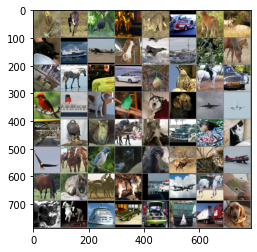

In [6]:
# Example of images

def imshow(img):
    """ show an image """
    img = img / 2. + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
#images, labels = train_data_iter.next()
images, labels = reference_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Display Noise functions on images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64
torch.Size([3, 96, 96])


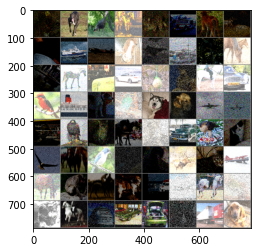

In [7]:
print(len(images[:]))
print(images[0].shape)
MM = copy.deepcopy(images)
MM = add_noise_to_images(MM,0.25,0.25,0.10,0.5,0.5)
# show noisy images
imshow(torchvision.utils.make_grid(MM))


Original Image


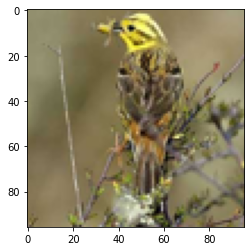

In [8]:
print("Original Image")
imshow(images[0])

Image with Gaussian noise


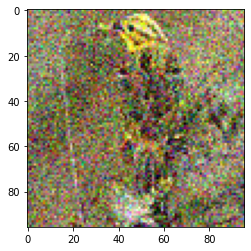

In [9]:
print("Image with Gaussian noise")
imshow(gaussian_noise(images[0],0.3))

Image with underexposure


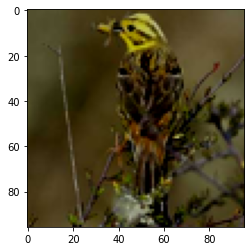

In [10]:
print("Image with underexposure")
imshow(underexposure(images[0],0.5))

Image with overexposure


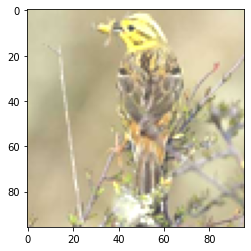

In [11]:
print("Image with overexposure")
imshow(overexposure(images[0],0.5))

Image with salt and pepper noise


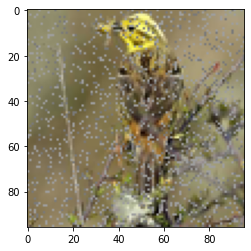

In [12]:
print("Image with salt and pepper noise")
imshow(salt_and_pepper_noise(images[0],0.1,0.05))

Image with motion blur


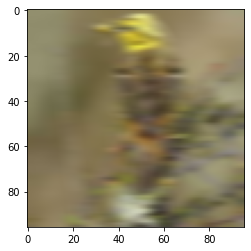

In [13]:
print("Image with motion blur")
imshow(motion_blur(images[0],3, 0.5))

 bird   dog  bird horse


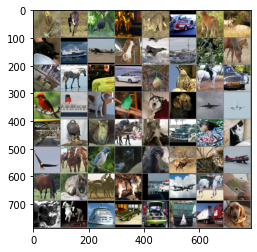

In [14]:
# Used in order to check that the images variable has not been overwritten
imshow(torchvision.utils.make_grid(images))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## New libraries for learning

In [15]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

## Network structure

In [16]:
# Image dimensions
channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_features = (height * width) * channels

def compute_conv_dim(dim_size,kernel_size,padding_size,stride_size):
    return int((dim_size - kernel_size + 2 * padding_size) / stride_size + 1)

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder and Decoder
        
        ############################
        # Encoder (downsampling)   #
        ############################
        self.enc_conv0 = Conv2d(3, 32, 3, stride=2, padding=1)
        #self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        #torch.nn.init.kaiming_normal_(self.enc_conv0.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm0 = nn.BatchNorm2d(32)

        self.enc_conv1 = Conv2d(32, 64, 3, stride=2, padding=1)
        #self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        #torch.nn.init.kaiming_normal_(self.enc_conv1.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm1 = nn.BatchNorm2d(64)

        self.enc_conv2 = Conv2d(64, 128, 3, stride=2, padding=1)
        #self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 
        #torch.nn.init.kaiming_normal_(self.enc_conv2.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm2 = nn.BatchNorm2d(128)

        self.enc_conv3 = Conv2d(128, 256, 3, stride=2, padding=1)
        #self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        #torch.nn.init.kaiming_normal_(self.enc_conv3.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm3 = nn.BatchNorm2d(256)

        self.enc_conv4 = Conv2d(256, 512, 3, stride=2, padding=1)
        # self.pool4 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        #torch.nn.init.kaiming_normal_(self.enc_conv4.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm4 = nn.BatchNorm2d(512)


        # bottleneck
        self.bottleneck_conv = Conv2d(512, 512, 3, stride=1, padding=1)
        #torch.nn.init.kaiming_normal_(self.bottleneck_conv.weight, mode='fan_in', nonlinearity='relu')
        self.norm_bottleneck = nn.BatchNorm2d(512)

        ############################
        # Decoder (UPsampling)     #
        ############################
        self.dec_conv0 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.kaiming_normal_(self.dec_conv0.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm0 = nn.BatchNorm2d(512)

        self.dec_conv1 = nn.ConvTranspose2d(512+256, 256, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.kaiming_normal_(self.dec_conv1.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm1 = nn.BatchNorm2d(256)

        self.dec_conv2 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.kaiming_normal_(self.dec_conv2.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm2 = nn.BatchNorm2d(128)

        self.dec_conv3 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.kaiming_normal_(self.dec_conv3.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm3 = nn.BatchNorm2d(64)

        self.dec_conv4 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.kaiming_normal_(self.dec_conv4.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm4 = nn.BatchNorm2d(32)

        self.final_deconv = nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, output_padding=0)
        #torch.nn.init.kaiming_normal_(self.final_deconv.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer

        # encoder
        e0 = F.relu(self.enc_norm0(self.enc_conv0(x)))
        e1 = F.relu(self.enc_norm1(self.enc_conv1(e0)))
        e2 = F.relu(self.enc_norm2(self.enc_conv2(e1)))
        e3 = F.relu(self.enc_norm3(self.enc_conv3(e2)))
        e4 = F.relu(self.enc_norm4(self.enc_conv4(e3)))

        # bottleneck
        b = F.relu(self.norm_bottleneck(self.bottleneck_conv(e4)))
        z = b

        # decoder
        d0 = F.relu(self.dec_norm0(self.dec_conv0(b)))
        skip0 = torch.cat([d0, e3], 1)
        d1 = F.relu(self.dec_norm1(self.dec_conv1(skip0)))
        skip1 = torch.cat([d1, e2], 1)
        d2 = F.relu(self.dec_norm2(self.dec_conv2(skip1)))
        skip2 = torch.cat([d2, e1], 1)
        d3 = F.relu(self.dec_norm3(self.dec_conv3(skip2)))
        skip3 = torch.cat([d3, e0], 1)
        d4 = self.dec_conv4(skip3)  # no activation, no batch normalization

        x_hat = self.final_deconv(d4)
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (enc_conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_bot

## Loss functions and optimizers

In [17]:
import torch.optim as optim

# Adam Optimizer with weight decay
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=1e-6) 

# Mean-Squared Error as our loss function
loss_function = nn.MSELoss()

## Test of one forward pass

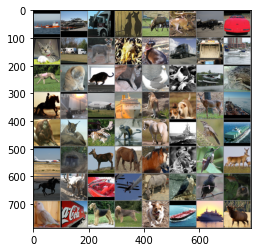

In [18]:
# Test of forward pass
x, y = next(iter(trainloader))
imshow(torchvision.utils.make_grid(x))

In [19]:
# Test of forward pass using cuda
if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x.shape = {x.shape}")
print(f"x_hat.shape = {outputs['x_hat'].shape}")
print(f"z.shape = {outputs['z'].shape}")
print(type(x))
x_hat = outputs['x_hat']
print(type(x_hat))

x.shape = torch.Size([64, 3, 96, 96])
x_hat.shape = torch.Size([64, 3, 96, 96])
z.shape = torch.Size([64, 512, 3, 3])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


## Train Network

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 200

train_loss = []
valid_loss = []
counter = 0
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not used here
    for x, y in trainloader:
        
        # Make a copy, so we do not overwrite the old data
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.1,0.3,0.3)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()

        outputs = net(x_noisy)
        x_hat = outputs['x_hat']

        loss = loss_function(x_hat, x)  #

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(testloader))
        
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.1,0.3,0.3)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()
        
        outputs = net(x_noisy)

        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    if (epoch % 10 == 0):
      print("Epoch", epoch, "/", num_epochs)

Epoch 10 / 200
Epoch 20 / 200
Epoch 30 / 200
Epoch 40 / 200
Epoch 50 / 200
Epoch 60 / 200
Epoch 70 / 200
Epoch 80 / 200
Epoch 90 / 200
Epoch 100 / 200
Epoch 110 / 200
Epoch 120 / 200
Epoch 130 / 200
Epoch 140 / 200
Epoch 150 / 200
Epoch 160 / 200
Epoch 170 / 200
Epoch 180 / 200
Epoch 190 / 200


## Plot Errors

Train loss in last epoch = 0.023007760524749756
Test loss in last epoch = 0.03133385628461838


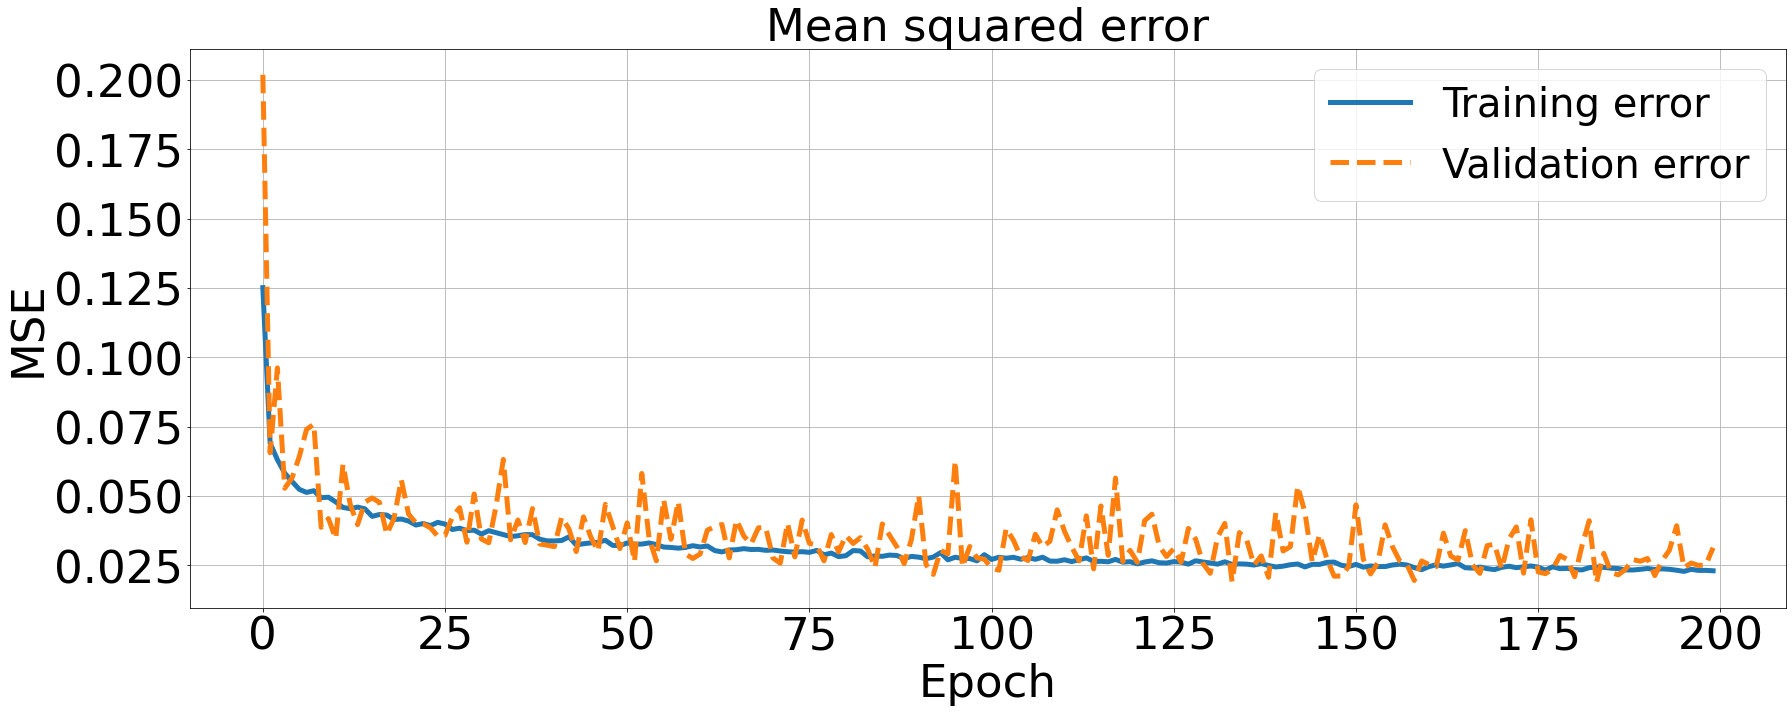

In [35]:
# Plot training error and validation error as function of number of epoch
csfont = {'fontname':'Arial'}

plt.figure(figsize=(25, 10))
x_axis_epoch = np.arange(epoch+1)
plt.plot(x_axis_epoch,train_loss, linewidth=5,label='Training error')
plt.plot(x_axis_epoch,valid_loss,'--',linewidth=5,label='Validation error')
plt.xlabel('Epoch',fontsize=45,**csfont)
plt.ylabel('MSE',fontsize=45,**csfont)
plt.title('Mean squared error',fontsize=45,**csfont)
plt.legend(loc="upper right", fontsize=40)
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.grid()
plt.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/graph.png',transparent=True)

# Print the last training error and the last validation error
print("Train loss in last epoch =", train_loss[-1])
print("Test loss in last epoch =", valid_loss[-1])

## Plot images with multiple noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


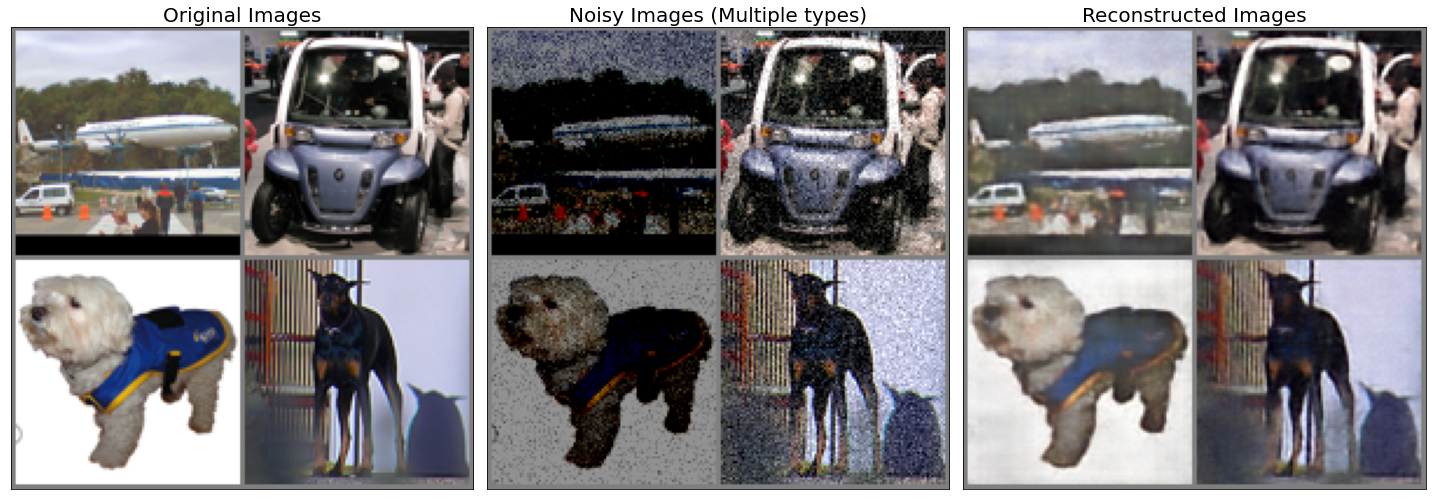

In [23]:
def unnormalize_image(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Pass batch through network
x, y = reference_data_iter.next()
x_noisy = copy.deepcopy(x)
x_noisy = add_noise_to_images(x_noisy, 0.1, 0.1, 0.1, 0.3, 0.3)
if cuda:
    x_noisy = x_noisy.cuda()
    x = x.cuda()
outputs = net(x_noisy)
x_hat = outputs['x_hat']

# Create plot of image reconstructions
f, axarr = plt.subplots(1, 3, figsize=(20, 20))
# remove the x and y ticks
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[9:13].cpu(), nrow=2)
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)

ax = axarr[1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[9:13].cpu(), nrow=2)
ax.imshow(unnormalize_image(x_noisy_grid))
ax.set_title("Noisy Images (Multiple types)", size=20)

ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[9:13].cpu(), nrow=2)
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/MultipleNoise.png',transparent=True) # Run this two times to get good results


## Plot images with multiple types of noise - in grid format

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


<Figure size 432x288 with 0 Axes>

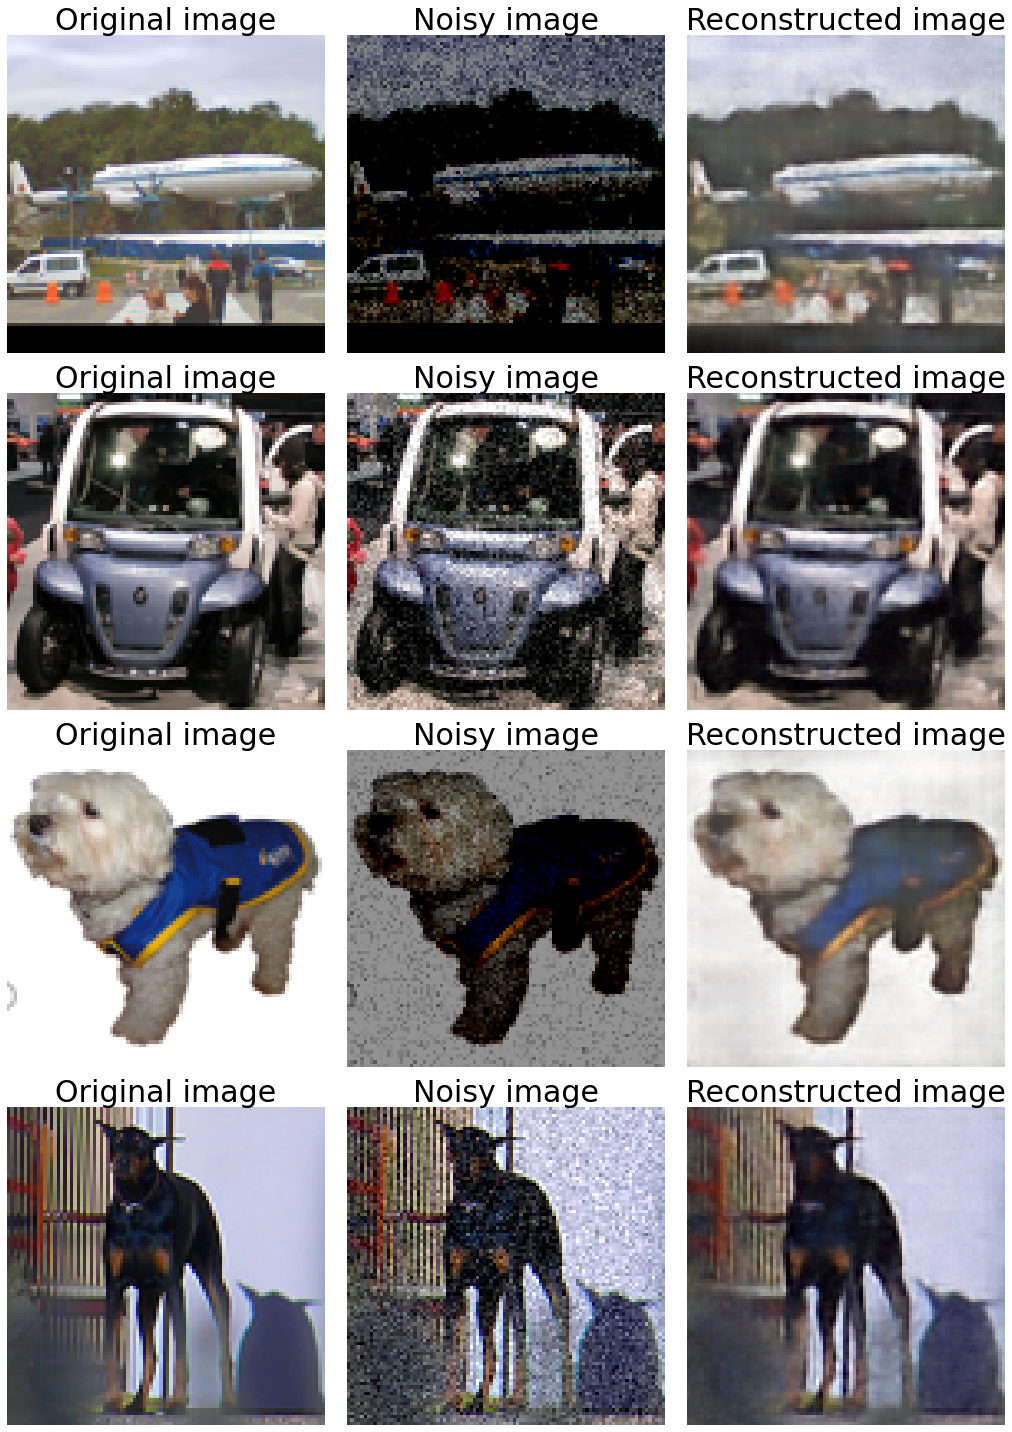

In [24]:
plt.figure()
## Another version of this plot
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), constrained_layout=True)
ax = axarr[0][0]
x_grid = torchvision.utils.make_grid(x[9].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=30)

ax = axarr[0][1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[9].cpu())
ax.imshow(unnormalize_image(x_noisy_grid))
ax.axis('off')
ax.set_title("Noisy image", size=30)

ax = axarr[0][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[9].cpu().detach())
#x_hat_grid = torchvision.utils.make_grid(x_hat_rgb)
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=30)

ax = axarr[1][0]
x_grid = torchvision.utils.make_grid(x[10].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=30)

ax = axarr[1][1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[10].cpu())
ax.imshow(unnormalize_image(x_noisy_grid))
ax.axis('off')
ax.set_title("Noisy image", size=30)

ax = axarr[1][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[10].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=30)

ax = axarr[2][0]
x_grid = torchvision.utils.make_grid(x[11].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=30)

ax = axarr[2][1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[11].cpu())
ax.imshow(unnormalize_image(x_noisy_grid))
ax.axis('off')
ax.set_title("Noisy image", size=30)

ax = axarr[2][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[11].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=30)

ax = axarr[3][0]
x_grid = torchvision.utils.make_grid(x[12].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=30)

ax = axarr[3][1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[12].cpu())
ax.imshow(unnormalize_image(x_noisy_grid))
ax.axis('off')
ax.set_title("Noisy image", size=30)

ax = axarr[3][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[12].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=30)

f.tight_layout()
plt.subplots_adjust(wspace=-0.54)
plt.savefig('drive/My Drive/ColabNotebooks/figures/MultipleNoise_2.png',transparent=True) 


## Gaussian noise added to images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


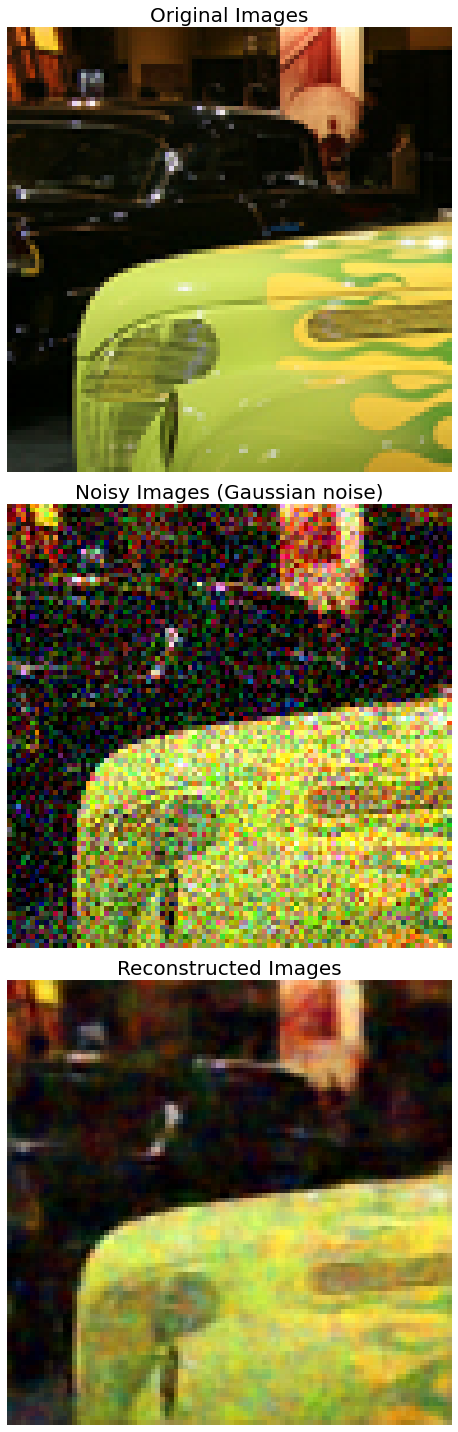

In [25]:
img_number = 18
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 1)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Gaussian noise)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/GaussianNoise.png') # Run this two times to get good results

## Salt and Pepper Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


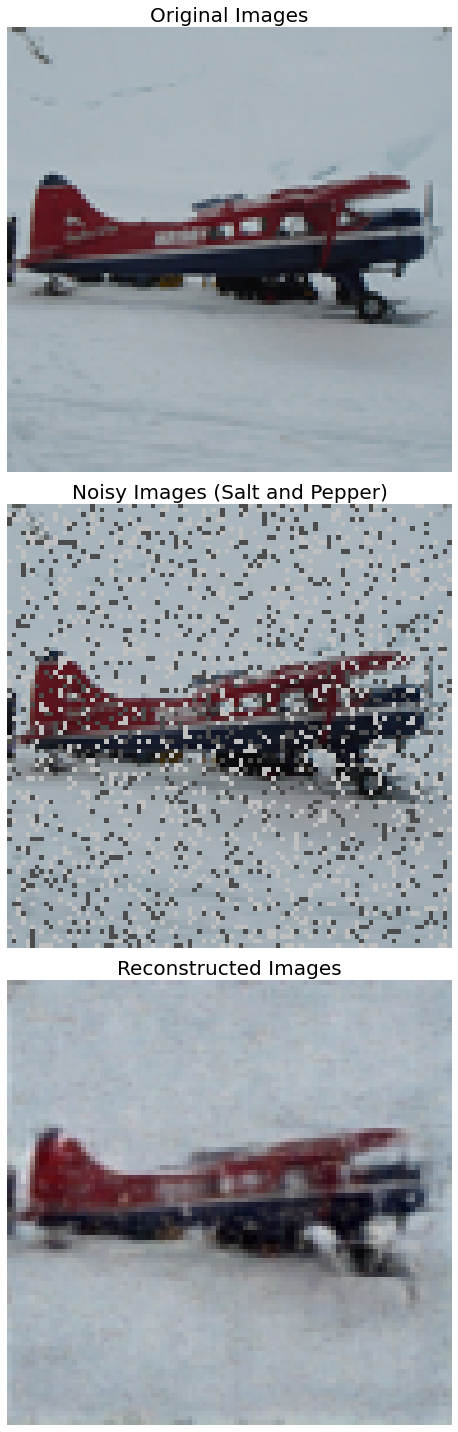

In [26]:
img_number = 47 # Used for comparison between networks
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 2)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Salt and Pepper)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/SaltPepper.png')

## Gaussian Grain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


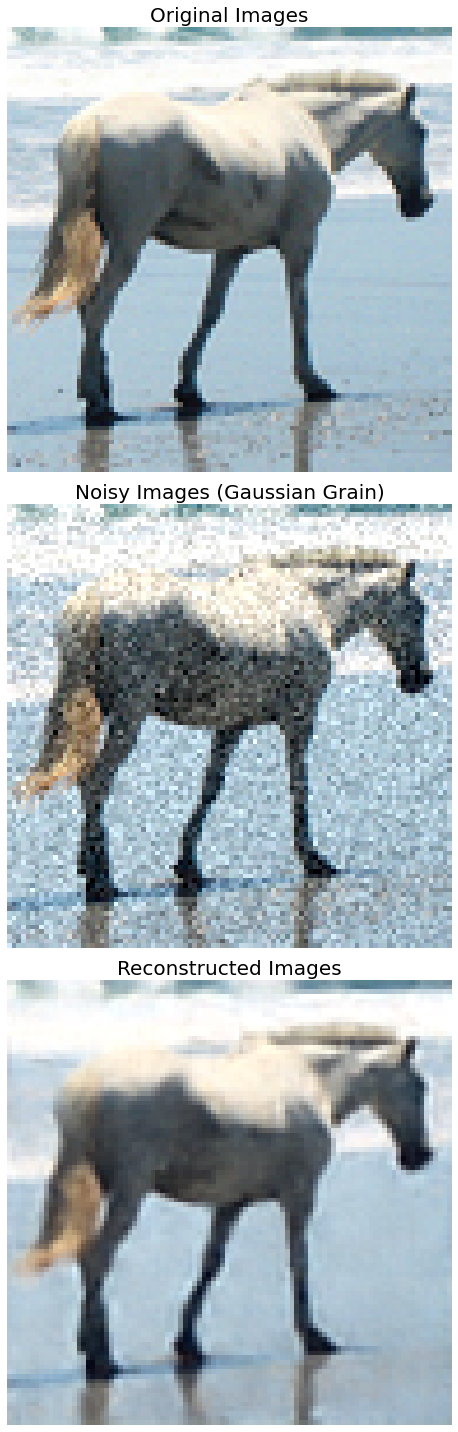

In [27]:
img_number = 17
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 3)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Gaussian Grain)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/GaussianGrain.png')

## Underexposure added to the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


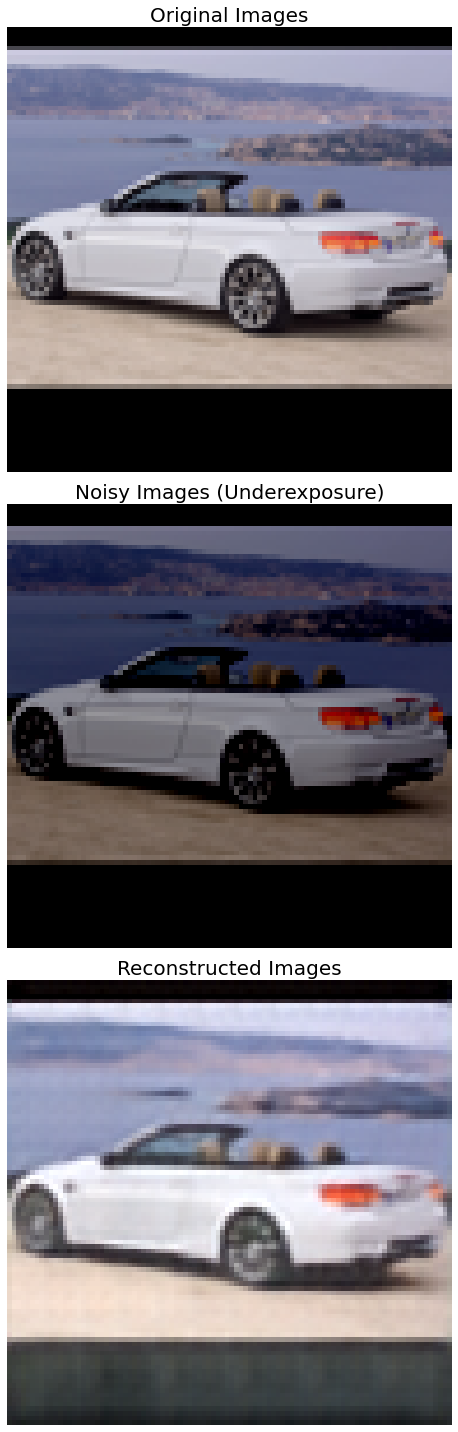

In [28]:
img_number = 19
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 4)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Underexposure)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/UnderExposure.png',transparent=True)

## Overexposure

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


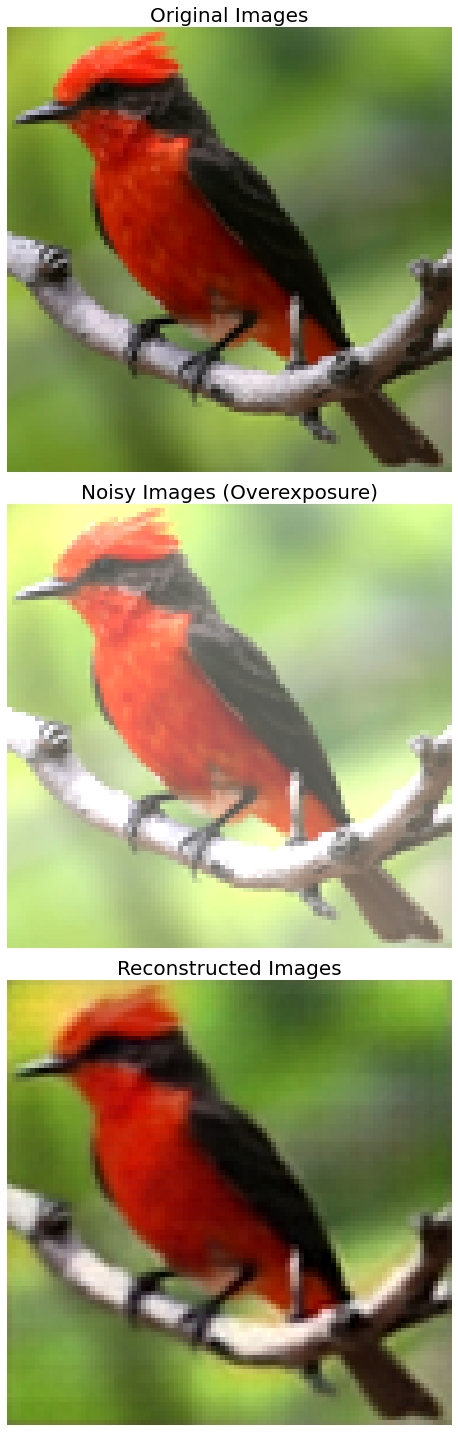

In [29]:
img_number = 24
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 5)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Overexposure)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/OverExposure.png',transparent=True)

## Motion blur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with script


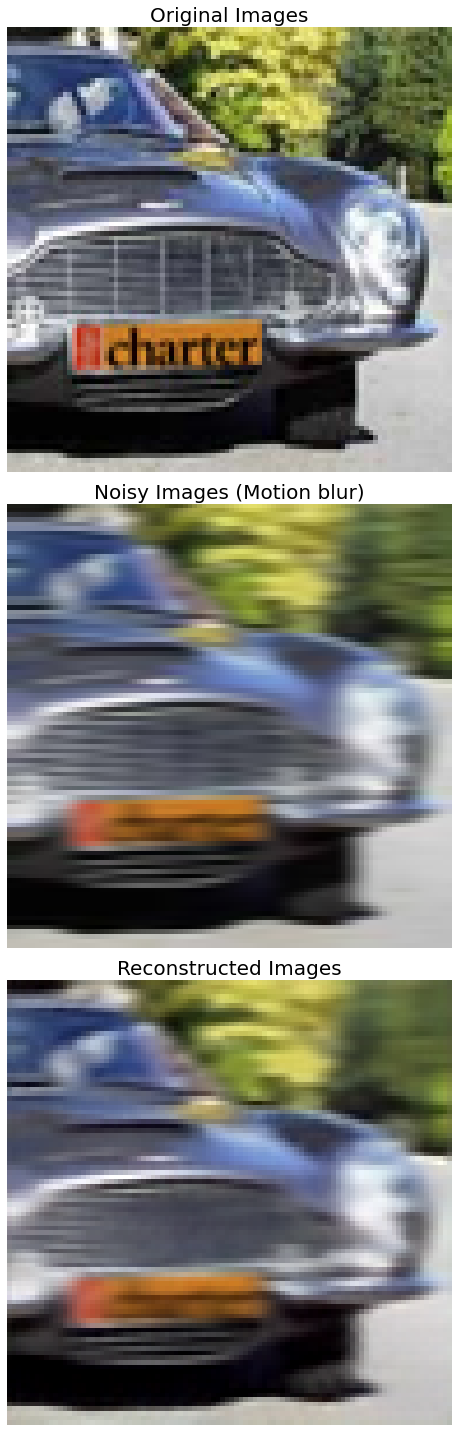

In [30]:
img_number = 23
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 6)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Motion blur)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/MotionBlur.png',transparent=True)
print("Done with script")

## Comparison of images with only one type of noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


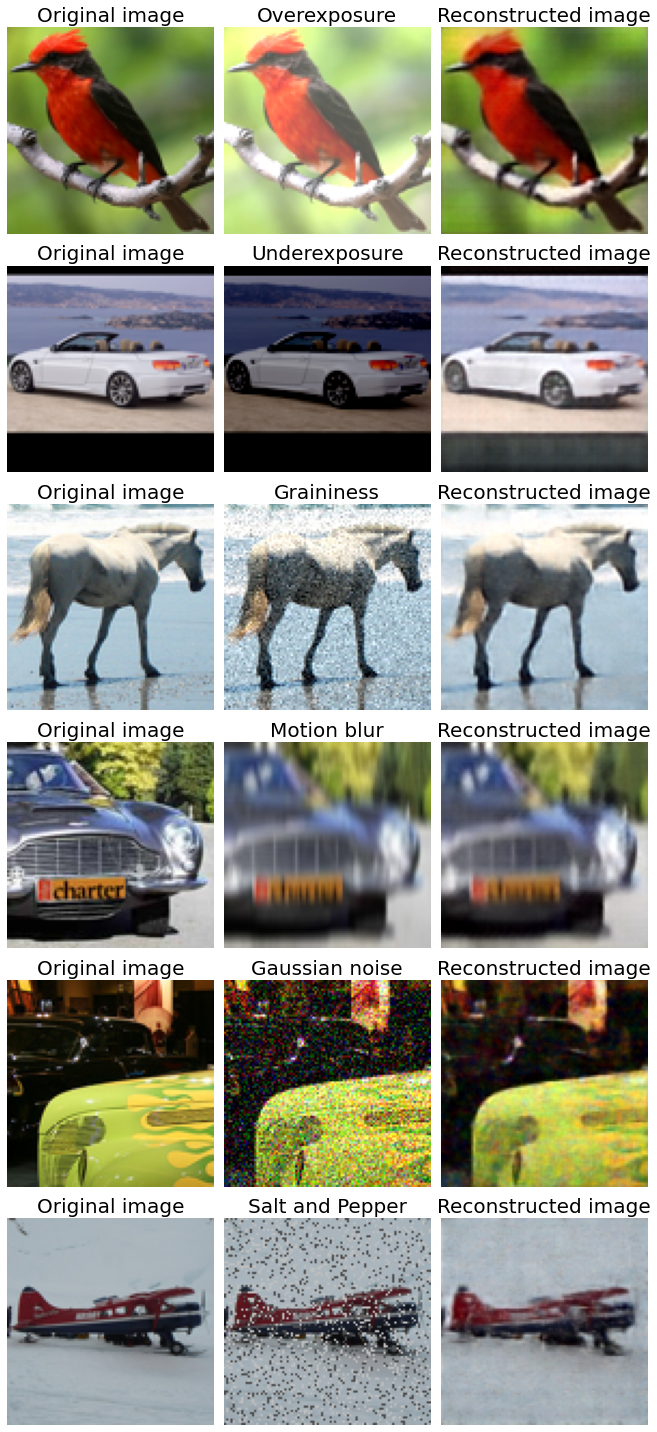

In [31]:
# Overexposure
img_number = 24
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 5)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

f, axarr = plt.subplots(nrows=6, ncols=3, figsize=(20, 20), constrained_layout=True)
ax = axarr[0][0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[0][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Overexposure", size=20)
ax = axarr[0][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)
#f.tight_layout()

# Underexposure
img_number = 19
x_underexposure, y = next(iter(referenceloader))
test_img = copy.deepcopy(x_underexposure)
test_img = test_noise_on_images(test_img, 4)
if cuda:
    test_img = test_img.cuda()
    x_underexposure = x_underexposure.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

ax = axarr[1][0]
x_grid = torchvision.utils.make_grid(x_underexposure[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[1][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Underexposure", size=20)
ax = axarr[1][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)
#f.tight_layout()

# Graininess
img_number = 17
x_grain, y = next(iter(referenceloader))
test_img = copy.deepcopy(x_grain)
test_img = test_noise_on_images(test_img, 3)
if cuda:
    test_img = test_img.cuda()
    x_grain = x_grain.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

ax = axarr[2][0]
x_grid = torchvision.utils.make_grid(x_grain[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[2][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Graininess", size=20)
ax = axarr[2][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)
#f.tight_layout()

# Blur
img_number = 23
x_blur, y = next(iter(referenceloader))
test_img = copy.deepcopy(x_blur)
test_img = test_noise_on_images(test_img, 6)
if cuda:
    test_img = test_img.cuda()
    x_blur = x_blur.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

ax = axarr[3][0]
x_grid = torchvision.utils.make_grid(x_blur[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[3][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Motion blur", size=20)
ax = axarr[3][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)

# Gaussian Noise
img_number = 18
x_gauss_noise, y = next(iter(referenceloader))
test_img = copy.deepcopy(x_gauss_noise)
test_img = test_noise_on_images(test_img, 1)
if cuda:
    test_img = test_img.cuda()
    x_gauss_noise = x_gauss_noise.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

ax = axarr[4][0]
x_grid = torchvision.utils.make_grid(x_gauss_noise[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[4][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Gaussian noise", size=20)
ax = axarr[4][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)

# Salt and Pepper
img_number = 47
x_salt_pepper, y = next(iter(referenceloader))
test_img = copy.deepcopy(x_salt_pepper)
test_img = test_noise_on_images(test_img, 2)
if cuda:
    test_img = test_img.cuda()
    x_salt_pepper = x_salt_pepper.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']

ax = axarr[5][0]
x_grid = torchvision.utils.make_grid(x_salt_pepper[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original image", size=20)
ax = axarr[5][1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Salt and Pepper", size=20)
ax = axarr[5][2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed image", size=20)

f.tight_layout()
plt.subplots_adjust(wspace=-0.78)

plt.savefig('drive/My Drive/ColabNotebooks/figures/multiple_Results.png',transparent=True)